# Imports

In [34]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Conexao com o Banco

In [ ]:
con = sqlite3.connect('../data/if.db')

# Questao 1

In [20]:
df_questao1 = pd.read_sql("""
    SELECT 
        provider,
        COUNT(session_id) AS count_session
    FROM 
        biometry_execution
    WHERE 
        status = 'PROVIDER_FAILED'
    GROUP BY 
        provider 
    ORDER BY 
        count(session_id) DESC
"""
, con)


In [17]:
df_questao1

,Provider,count_session
0,A,40
1,B,8
2,C,3


C:\Users\Thales\AppData\Local\Temp\ipykernel_25788\3763014770.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Provider', y='count_session', data=df_questao1, palette=custom_palette)
C:\Users\Thales\AppData\Local\Temp\ipykernel_25788\3763014770.py:2: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(x='Provider', y='count_session', data=df_questao1, palette=custom_palette)


<Axes: xlabel='Provider', ylabel='count_session'>

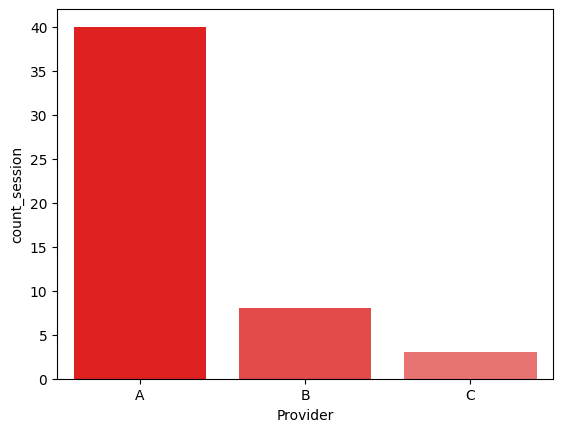

In [29]:
custom_palette = sns.light_palette("red", reverse=True)
sns.barplot(x='Provider', y='count_session', data=df_questao1, palette=custom_palette)

# Falta a quebra por status aqui (match, not_match, provider_failed)

# Questao 2

In [40]:
df_questao2 = pd.read_sql("""
   select 
    d.Category,
    count(d.Driver_ID) as count_drivers

    from biometry as b
    left join drivers as d on b.Driver_ID = d.Driver_ID
    where status = 'NOT_MATCH'
    group by Category
    order by count(d.Driver_ID) desc

"""
, con)


In [41]:
df_questao2

,Category,count_drivers
0,Bronze,25
1,Prata,20
2,Iniciante,11
3,Ouro,4
4,Diamante,1


C:\Users\Thales\AppData\Local\Temp\ipykernel_25788\3347901202.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)
C:\Users\Thales\AppData\Local\Temp\ipykernel_25788\3347901202.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)


Text(0, 0.5, 'Categoria de Entregador')

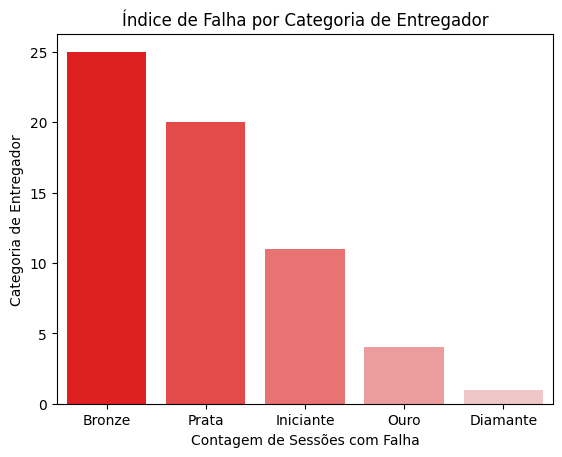

In [42]:
custom_palette = sns.light_palette("red", reverse=True)
sns.barplot(x='Category', y='count_drivers', data=df_questao2, palette=custom_palette)


plt.title('Índice de Falha por Categoria de Entregador')
plt.xlabel('Contagem de Sessões com Falha')
plt.ylabel('Categoria de Entregador')


# Questao 3

In [43]:
df_questao3 = pd.read_sql("""
 WITH tb_similaridade_max AS (
    SELECT
        session_id,
        MAX(similarity) AS max_similaridade
    FROM
        biometry_execution
    GROUP BY
        session_id
),

tb_similaridade_real AS (
    SELECT 
        COUNT(session_id) AS count_session_id,
        CASE 
            WHEN max_similaridade > 0.8 THEN 'match'
            WHEN max_similaridade IS NULL THEN 'provider_failed'
            ELSE 'not_match' 
        END AS similaridade,
        'similaridade_real' AS similaridade_real
    FROM 
        tb_similaridade_max
    GROUP BY 
        CASE 
            WHEN max_similaridade > 0.8 THEN 'match'
            ELSE 'not_match' 
        END

),


tb_indice_similaridade_real as (
    SELECT
        similaridade,
        count_session_id,
        (select count(distinct Session_ID) from biometry_execution) as total_sessoes,
        1.0 * count_session_id /  (select count(distinct Session_ID) from biometry_execution) as indice_similaridade,
        'similaridade_real' as classificacao
        

    FROM 
        tb_similaridade_real
    GROUP BY
        similaridade
),

tb_similaridade_projetada AS (
    SELECT 
        COUNT(session_id) AS count_session_id,
        CASE 
            WHEN max_similaridade > 0.9 THEN 'match'
            WHEN max_similaridade IS NULL THEN 'provider_failed'
            ELSE 'not_match' 
        END AS similaridade,
        'projetada' AS tipo
    FROM 
        tb_similaridade_max
    GROUP BY 
        CASE 
            WHEN max_similaridade > 0.9 THEN 'match'
            ELSE 'not_match' 
        END
),

tb_indice_similaridade_projetada as (
    SELECT
        similaridade,
        count_session_id,
        (select count(distinct Session_ID) from biometry_execution) as total_sessoes,
        1.0 * count_session_id /  (select count(distinct Session_ID) from biometry_execution) as indice_similaridade,
        'similaridade_projetada' as classificacao
        

    FROM 
        tb_similaridade_projetada
    GROUP BY
        similaridade
)

select * from tb_indice_similaridade_real

union

select * from tb_indice_similaridade_projetada 





"""
, con)


In [44]:
df_questao3

,similaridade,count_session_id,total_sessoes,indice_similaridade,classificacao
0,match,281,497,0.565392,similaridade_projetada
1,match,432,497,0.869215,similaridade_real
2,not_match,65,497,0.130785,similaridade_real
3,not_match,216,497,0.434608,similaridade_projetada


Text(0, 0.5, 'Number of Customers')

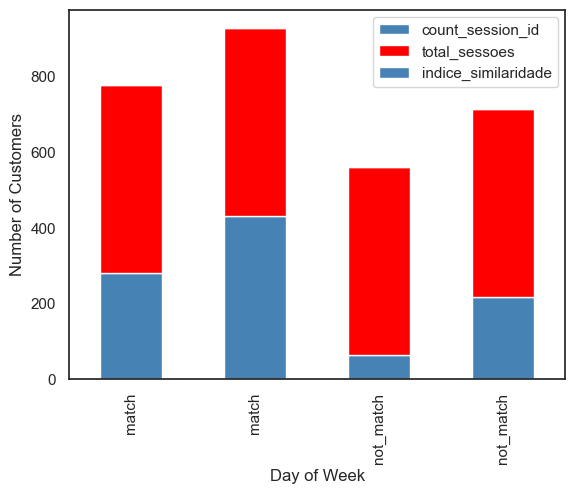

In [46]:
#set seaborn plotting aesthetics
sns.set(style='white')

#create stacked bar chart
df_questao3.set_index('similaridade').plot(kind='bar', stacked=True, color=['steelblue', 'red'])

plt.xlabel('Day of Week')
plt.ylabel('Number of Customers')